<center>
<img src="warwick-logo.png">
<h1>Interoperability between scientific computing codes with Python</h1>
<h3>James Kermode</h3>
Warwick Centre for Predictive Modelling / School of Engineering<br>
University of Warwick
<br>
<br>
**Centre for Scientific Computing seminar, University of Warwick - 16 Nov 2015**

<img src="WCPM_logo_text.png" width="50%">

</center>

<br>
<br>
<br>
<br>

## Introduction

- Interfacing codes allows existing tools to be combined
- Produce something that is more than the sum of the constituent parts 
- This is a general feature of modern scientific computing, with many well-documented packages and libraries available
- Python has emerged as the de facto standard “glue” language
- Codes that have a Python interface can be combined in complex ways

<img src="https://www.python.org/static/community_logos/python-logo-master-v3-TM.png" width="40%" >

## Motivation

- My examples are from atomistic materials modelling and electronic structure, but approach is general
- All the activities I'm interested in require *robust*, *automated* coupling of two or more codes
- For example, my current projects include:
    - developing and applying multiscale methods
    - generating interatomic potentials
    - uncertainty quantification

<img src="multiscale.png" width="70%">

## Case study - concurrent coupling of density functional theory and interatomic potentials

<img src="boron-crack-100dpi.png" width="60%">

*J.R. Kermode, L. Ben-Bashat, F. Atrash, J.J. Cilliers, D. Sherman and A. De Vita, [Macroscopic scattering of cracks initiated at single impurity atoms.](http://www.nature.com/ncomms/2013/130912/ncomms3441/full/ncomms3441.html) Nat. Commun. 4, 2441 (2013).*

 - File-based communication good enough for many projects that combine codes
 - Here, efficient simlulations require a programmatic interface between QM and MM codes
 - Keeping previous solution in memory, wavefunction extrapolation, etc.
 - In general, deep interfaces approach bring much wider benefits

#  Benefits of Scripting Interfaces

**Primary:**
 - Automated preparation of input files
 - Analysis and post-processing
 - Batch processing
 
**Secondary:**
 - Expand access to advanced feautures to less experienced programmers
 - Simplify too-level programs
 - Unit and regression testing framework
 
**Longer term benefits:**
 - Encourages good software engineering in main code - modularity, well defined APIs
 - Speed up development of new algorithms by using an appropriate mixture of high- and low-level languages


# Python scripting for interoperability

- Python has emerged as *de facto* "glue" language for atomistic simulations
    - [numpy](http://www.numpy.org/)/[scipy](http://scipy.org/) ecosystem
    - [Matplotlib](http://matplotlib.org/) plotting/interactive graphics
    - [Jupyter](https://jupyter.org/)/IPython notebooks encourage reproducible research
    - [Anaconda](https://jupyter.org/) distribution and package management system
    
![scipy](scipy-stack.png)

http://www.scipy.org

## Atomic Simulation Environment (ASE)

- Within atomistic modelling, standard for scripting interfaces is ASE
- Wide range of calculators, flexible (but not too flexible) data model
- Can use many codes as drop-in replacements
- Collection of parsers aids validation and verification (cf. DFT $\Delta$-code project)
- Coupling $N$ codes requires maintaining $N$ parsers/interfaces to be maintained, not $N^2$ input-output converters
- High-level functionality can be coded generically, or imported from other packages (e.g. `spglib`, `phonopy`) using minimal ASE-compatible API

https://wiki.fysik.dtu.dk/ase/

## QUIP - **QU**antum mechanics and **I**nteratomic **P**otentials

- General-purpose library to manipulate atomic configurations, grew up in parallel with ASE 
- Includes interatomic potentials, tight binding, external codes such as Castep
- Developed at Cambridge, NRL and King's College London over $\sim10$ years
- Started off as a pure Fortran 95 code, but recently been doing more and more in Python
- `QUIP` has a full, deep Python interface, `quippy`, auto-generated from Fortran code using `f90wrap`, giving access to all public subroutines, derived types (classes) and data

![quippy](http://libatoms.github.io/QUIP/_static/hybrid.png)

http://libatoms.github.io/QUIP

## Interactive demonstations

- Using live IPython notebook linked to local Python kernel - could also be remote parallel cluster
- Static view of notebook can be rendered as `.html` or `.pdf`, or as executable Python script

In [57]:
%pylab inline
import numpy as np
from chemview import enable_notebook
from matscipy.visualise import view
enable_notebook()

Populating the interactive namespace from numpy and matplotlib


## Example: vacancy formation energy in silicon

- Typical example workflow, albeit simplified
- Couples several tools
    - Generate structure with ASE lattice tools
    - Stillinger-Weber potential implementation from QUIP
    - Relaxations with generic LBFGS optimiser from ASE

In [58]:
from ase.lattice import bulk
from ase.optimize import LBFGSLineSearch
from quippy.potential import Potential

si = bulk('Si', a=5.44, cubic=True)
sw_pot = Potential('IP SW') # call into Fortran code
si.set_calculator(sw_pot)
e_bulk_per_atom = si.get_potential_energy()/len(si)

vac = si * (3, 3, 3)
del vac[len(vac)/2]
vac.set_calculator(sw_pot)
p0 = vac.get_positions()
opt = LBFGSLineSearch(vac)
opt.run(fmax=1e-3)
p1 = vac.get_positions()
u = p1 - p0

e_vac = vac.get_potential_energy()
print 'SW vacancy formation energy', e_vac - e_bulk_per_atom*len(vac), 'eV'

LBFGSLineSearch:   0  13:20:46     -927.656224       0.0402
LBFGSLineSearch:   1  13:20:47     -927.656744       0.0233
LBFGSLineSearch:   2  13:20:47     -927.657016       0.0109
LBFGSLineSearch:   3  13:20:47     -927.657090       0.0094
LBFGSLineSearch:   4  13:20:47     -927.657155       0.0055
LBFGSLineSearch:   5  13:20:48     -927.657201       0.0031
LBFGSLineSearch:   6  13:20:48     -927.657214       0.0017
LBFGSLineSearch:   7  13:20:48     -927.657219       0.0018
LBFGSLineSearch:   8  13:20:48     -927.657223       0.0012
LBFGSLineSearch:   9  13:20:49     -927.657225       0.0011
LBFGSLineSearch:  10  13:20:49     -927.657226       0.0004
SW vacancy formation energy 4.33384049255 eV


# Inline visualisation

- Chemview IPython plugin uses WebGL for fast rendering of molecules
- Didn't have an ASE interface, but was quick and easy to add one (~15 lines of code)

In [59]:
view(vac, np.sqrt(u**2).sum(axis=1), bonds=False)

## DFT example - persistent connection,  checkpointing

- Doing MD or minimisation within a DFT code typically much faster than repeated single-point calls
- `SocketCalculator` from `matscipy` package keeps code running, feeding it new configurations via POSIX sockets (local or remote)
- Use high-level algorithms to move the atoms in complex ways, but still take advantage of internal optimisations like wavefunction extrapolation
- Checkpointing after each force or energy call allows seamless continuation of complex workflows
- Same Python script can be submitted as jobscript on cluster and run on laptop

In [60]:
import distutils.spawn as spawn
from matscipy.socketcalc import SocketCalculator, VaspClient
from matscipy.checkpoint import CheckpointCalculator
from ase.lattice import bulk
from ase.optimize import FIRE

mpirun = spawn.find_executable('mpirun')
vasp = spawn.find_executable('vasp')

vasp_client = VaspClient(client_id=0, npj=2, ppn=12,
                         exe=vasp, mpirun=mpirun, parmode='mpi', 
                         lwave=False, lcharg=False, ibrion=13,
                         xc='PBE', kpts=[2,2,2])
vasp = SocketCalculator(vasp_client)
chk_vasp = CheckpointCalculator(vasp, 'vasp_checkpoint.db')

si = bulk('Si', a=5.44, cubic=True)
si.set_calculator(chk_vasp)
e_bulk_per_atom = si.get_potential_energy()/len(si)

vac3 = si.copy()
del vac3[0]
vac3.set_calculator(chk_vasp)

opt = FIRE(vac3)
opt.run(fmax=1e-3)
e_vac3 = vac3.get_potential_energy()
print 'VASP vacancy formation energy', e_vac3 - e_bulk_per_atom*len(vac3), 'eV'

# {__init__}: No nsw key in vasp_args, setting nsw=1000000
# {server_activate}: AtomsServer running on hudson.local 127.0.0.1:51013 with njobs=1
FIRE:   0  13:23:03      -35.191978       0.2026
FIRE:   1  13:23:03      -35.193557       0.1925
FIRE:   2  13:23:03      -35.196437       0.1734
FIRE:   3  13:23:04      -35.200040       0.1458
FIRE:   4  13:23:04      -35.203660       0.1102
FIRE:   5  13:23:04      -35.206586       0.0694
FIRE:   6  13:23:04      -35.208236       0.0252
FIRE:   7  13:23:04      -35.208278       0.0204
FIRE:   8  13:23:04      -35.208282       0.0209
FIRE:   9  13:23:04      -35.208290       0.0203
FIRE:  10  13:23:05      -35.208303       0.0193
FIRE:  11  13:23:05      -35.208319       0.0181
FIRE:  12  13:23:05      -35.208337       0.0167
FIRE:  13  13:23:05      -35.208357       0.0161
FIRE:  14  13:23:05      -35.208377       0.0136
FIRE:  15  13:23:05      -35.208400       0.0126
FIRE:  16  13:23:05      -35.208422       0.0099
FIRE:  17  13:23:05   

## File-based interfaces vs. Native interfaces

- ASE provides file-based interfaces to a number of codes - useful for high throughput
- However, file-based interfaces to electronic structure codes can be slow and/or incomplete and parsers are hard to keep up to date and robust
- Standardised output (e.g. chemical markup language, XML) and robust parsers are part of solution
- [NoMaD Centre of Excellence](http://nomad-coe.eu/) will produce parsers for top ~40 atomistic codes
- Alternative: native interfaces provide a much deeper wrapping, exposing full public API of code to script writers
    - e.g. GPAW, LAMMPSlib, new Castep Python interface

![nomad](http://nomad-coe.eu/uploads/images/nomad_logo_v2.png)

## Fortran/Python interfacing

- Despite recent increases in use of high-level languages, there's still lots of high-quality Fortran code around
- Adding "deep" Python interfaces to existing codes is another approach
- Future proofing: anything accessible from Python is available from other high-level languages too (e.g. Julia)


<img src="f90wrap.png" align="left" width="250" style="padding:30px;">


# `f90wrap` adds derived type support to `f2py`

- There are many automatic interface generators for C++ codes (e.g. SWIG or Boost.Python), but not many support modern Fortran
    - [f2py](https://sysbio.ioc.ee/projects/f2py2e/) scans Fortran 77/90/95 codes, generates Python interfaces
    - Great for individual routines or simple codes: portable, compiler independent, good array support
    - No support for modern Fortran features: derived types, overloaded interfaces
- Number of follow up projects, none had all features we needed
- `f90wrap` addresses this by generating an additional layer of wrappers
    - Supports derived types, module data, efficient array access, Python 2.6+ and 3.x

https://github.com/jameskermode/f90wrap

# Example: wrapping  the `bader` code

- Widely used code for post-processing charge densities to construct Bader volumes
- Python interface would allow code to be used as part of workflows without needing file format converters, I/O, etc.
- Downloaded [source](http://theory.cm.utexas.edu/henkelman/code/bader/), used `f90wrap` to *automatically* generate a deep Python interface with very little manual work

Generation and compilation of wrappers:

    f90wrap -v -k kind_map -I init.py -m bader \
         kind_mod.f90 matrix_mod.f90 \
         ions_mod.f90 options_mod.f90 charge_mod.f90 \
         chgcar_mod.f90 cube_mod.f90 io_mod.f90 \
         bader_mod.f90 voronoi_mod.f90 multipole_mod.f90

    f2py-f90wrap -c -m _bader f90wrap_*.f90 -L. -lbader

In [61]:
from gpaw import restart
si, gpaw = restart('si-vac.gpw')
rho = gpaw.get_pseudo_density()


  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  0.12.0.13366
 |___|_|             

User:   jameskermode@hudson.local
Date:   Mon Nov 16 13:29:50 2015
Arch:   x86_64
Pid:    46591
Python: 2.7.10
gpaw:   //anaconda/lib/python2.7/site-packages/gpaw
_gpaw:  //anaconda/lib/python2.7/site-packages/_gpaw.so
ase:    //anaconda/lib/python2.7/site-packages/ase (version 3.10.0)
numpy:  //anaconda/lib/python2.7/site-packages/numpy (version 1.10.1)
scipy:  //anaconda/lib/python2.7/site-packages/scipy (version 0.16.0)
units:  Angstrom and eV
cores:  1

Memory estimate
---------------
Process memory now: 480.42 MiB
Calculator  67.31 MiB
    Density  27.12 MiB
        Arrays  4.35 MiB
        Localized functions  21.09 MiB
        Mixer  1.67 MiB
    Hamiltonian  7.66 MiB
        Arrays  2.85 MiB
        XC  0.00 MiB
        Poisson  3.24 MiB
        vbar  1.57 MiB
    Wavefunctions  32.53 MiB
        Arrays psit_nG  9.38 MiB
        Eigensolver  11.17 MiB
   

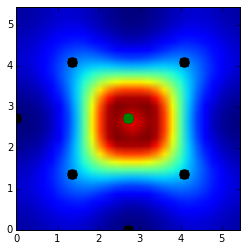

In [62]:
atom = 5
plot(si.positions[:, 0], si.positions[:, 1], 'k.', ms=20)
plot(si.positions[atom, 0], si.positions[5, 1], 'g.', ms=20)
imshow(rho[:,:,0], extent=[0, si.cell[0,0], 0, si.cell[1,1]])

In [63]:
import bader
bdr = bader.bader(si, rho)

In [66]:
bdr.nvols

24

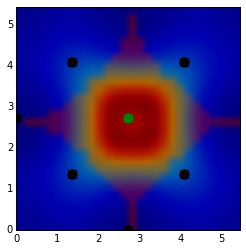

In [67]:
# collect Bader volumes associated with atom #5
mask = np.zeros_like(rho, dtype=bool)
for v in (bdr.nnion == atom+1).nonzero()[0]:
    mask[bdr.volnum == v+1] = True
    
plot(si.positions[:, 0], si.positions[:, 1], 'k.', ms=20)
plot(si.positions[atom, 0], si.positions[5, 1], 'g.', ms=20)
imshow(rho[:,:,0],  extent=[0, si.cell[0,0], 0, si.cell[1,1]])
imshow(mask[:,:,0], extent=[0, si.cell[0,0], 0, si.cell[1,1]], alpha=.6)

# Wrapping Castep with f90wrap

- `f90wrap` can now wrap large and complex codes like the Castep electronic structure code, providing deep access to internal data on-the-fly 
- Summer internship by Greg Corbett at STFC in 2014 produced proof-of-principle implementation
- Results described in [RAL technical report](https://epubs.stfc.ac.uk/work/18048381)
- Since then I've tidied it up a little and added a minimal high-level ASE-compatibility layer, but there's plenty more still to be done

![Castep](http://www.castep.org/files/CASTEP_Logo_mini-01.png)

## Current Features

- Implemented in Castep development release:
        make python
- Restricted set of source files currently wrapped, can be easily expanded.
        Utility:     constants.F90 algor.F90 
                     comms.serial.F90
                     io.F90 trace.F90 
                     license.F90 buildinfo.f90
        Fundamental: parameters.F90 cell.F90 basis.F90 
                     ion.F90 density.F90 wave.F90
        Functional:  model.F90 electronic.F90 firstd.f90
        
- Already **far** too much to wrap by hand!
   - 35 kLOC Fortran and 55 kLOC Python auto-generated 
   - 23 derived types 
   - ~2600 subroutines/functions

## What is wrapped?
- Module-level variables: `current_cell`, etc.
- Fortran derived types visible as Python classes: e.g. `Unit_Cell`
- Arrays (including arrays of derived types) - no copying necessary to access/modify data in numerical arrays e.g. `current_cell%ionic_positions`
- Documentation strings extracted from source code
- Dynamic introspection of data and objects
- Error catching: `io_abort()` raises `RuntimeError` exception, allowing post mortem debugging
- Minimal ASE-compatible high level interface

# Test drive

In [68]:
import castep

In [69]:
#castep.
#castep.cell.Unit_Cell.
castep.model.model_wave_read?

## Single point calculation

In [70]:
from ase.lattice.cubic import Diamond
atoms = Diamond('Si')
calc = castep.calculator.CastepCalculator(atoms=atoms)
atoms.set_calculator(calc)
e = atoms.get_potential_energy()
f = atoms.get_forces()
print 'Energy', e, 'eV'
print 'Forces (eV/A):'
print f

Energy -401.419912223 eV
Forces (eV/A):
[[-0.12335761 -0.12340173 -0.12332035]
 [ 0.12335492  0.12337595  0.12332078]
 [-0.123409   -0.1233628  -0.12327315]
 [ 0.12330122  0.1233129   0.12334265]
 [-0.12330156 -0.1234069  -0.12336426]
 [ 0.12335953  0.12338503  0.12331035]
 [-0.12334791 -0.12329187 -0.12338976]
 [ 0.1234004   0.12338941  0.12337375]]


## Interactive introspection

In [74]:
#calc.model.eigenvalues
#calc.model.wvfn.coeffs
#calc.model.cell.ionic_positions.T
#calc.model.wvfn.
#calc.parameters.cut_off_energy

(-0.5, 0.5)

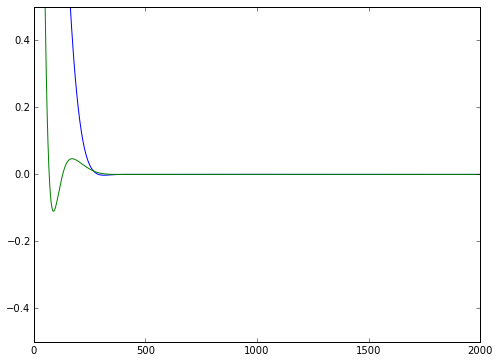

In [75]:
figsize(8,6)
plot(castep.ion.get_array_core_radial_charge())
plot(castep.ion.get_array_atomic_radial_charge())
ylim(-0.5,0.5)

## Visualise charge density isosurfaces on-the-fly

In [76]:
# grid points, in Angstrom
real_grid = (castep.basis.get_array_r_real_grid()*
             castep.io.io_atomic_to_unit(1.0, 'ang'))
resolution = [castep.basis.get_ngx(), 
              castep.basis.get_ngy(), 
              castep.basis.get_ngz()]
origin = np.array([real_grid[i, :].min() for i in range(3)])
extent = np.array([real_grid[i, :].max() for i in range(3)]) - origin

# charge density resulting from SCF
den = calc.model.den.real_charge.copy()
den3 = (den.reshape(resolution, order='F') / 
        castep.basis.get_total_fine_grid_points())

# visualise system with isosurface of charge density at 0.002
viewer = view(atoms)
viewer.add_isosurface_grid_data(den3, origin, extent, resolution,
                                isolevel=0.002, color=0x0000ff,
                                style='solid')
viewer

## Postprocessing/steering of running calculations

- Connect Castep and Bader codes without writing any explicit interface or converter

In [77]:
from display import ListTable
from bader import bader
bdr = bader(atoms, den3)

rows = ListTable()
rows.append(['<b>{0}</b>'.format(hd) for hd in ['Ion', 'Charge', 'Volume']])
for i, (chg, vol) in enumerate(zip(bdr.ionchg, bdr.ionvol)):
    rows.append(['{0:.2f}'.format(d) for d in [i, chg, vol] ])
rows

Ion,Charge,Volume
0.00,0.03,78.00
1.00,0.06,178.35
2.00,0.05,141.46
3.00,0.07,193.28
4.00,0.04,106.92
5.00,0.06,176.24
6.00,0.03,76.36
7.00,0.04,129.82


So far this is just analysis/post-processing, but could easily go beyond this and steer calculations based on results of e.g. Bader analysis.

## Updating data inside a running Castep instance

We can move the ions and continue the calculation without having to restart electronic minimisation from scratch (or do any I/O of `.check` files etc.). Here's how the core of the electronic minimisation is coded in Python, almost entirely calling auto-generated routines:

```python
    new_cell = atoms_to_cell(atoms, kpts=self.kpts)
    castep.cell.copy(new_cell, self.current_cell)
    self.model.wvfn.have_beta_phi = False
    castep.wave.wave_sorthonormalise(self.model.wvfn)
    self.model.total_energy, self.model.converged = \
        electronic_minimisation(self.model.wvfn, 
                                self.model.den, 
                                self.model.occ, 
                                self.model.eigenvalues, 
                                self.model.fermi_energy)
    self.results['energy'] = io_atomic_to_unit(self.model.total_energy, 'eV')
```

In [78]:
castep.wave.wave_orthogonalise?

## Example - geometry optimisation

Use embedded Castep efficiently as a standard ASE calculator, giving access to all of the existing high-level algorithms: geometry optimisation, NEB, basin hopping, etc.
 - Compared to file-based interface, save overhead of restarting Castep for each call
 - Reuse electronic model from one ionic configuration to the next
 - Wavefunction and charge density extrapolation possible just as in MD

In [80]:
from ase.optimize import LBFGS
atoms.rattle(0.01)
opt = LBFGS(atoms)
opt.run(fmax=0.1)

LBFGS:   0  13:42:06     -401.372736       0.0903


## Developing and testing new high-level algorithms

Having a Python interface makes it quick to try out new high-level algorithms. 

- e.g. I'm working on a general-purpose preconditioner for geometry optimisation with Christoph Ortner (Warwick), let's try that with Castep
- This was implemented in a general purpose Python code by Warwick summer student John Woolley, just plug in Castep and off we go!

In [81]:
from ase.lattice import bulk
import castep
import preconpy.lbfgs as lbfgs
import preconpy.precon as precon
from preconpy.utils import LoggingCalculator

atoms = bulk('Si', cubic=True)
s = atoms.get_scaled_positions()
s[:, 0] *= 0.98
atoms.set_scaled_positions(s)
initial_atoms = atoms
log_calc = LoggingCalculator(None)

for precon, label in zip([None, precon.Exp(A=3, use_pyamg=False)],
                         ['No preconditioner', 'Exp preconditioner']):
    print label
    atoms = initial_atoms.copy()
    calc = castep.calculator.CastepCalculator(atoms=atoms)
    log_calc.calculator = calc
    log_calc.label = label
    
    atoms.set_calculator(log_calc)    
    opt = lbfgs.LBFGS(atoms, 
                      precon=precon, 
                      use_line_search=False)
    opt.run(fmax=1e-2)

No preconditioner
LBFGS:   0  13:43:33     -401.438808       0.2319
LBFGS:   1  13:43:35     -401.442860       0.2484
LBFGS:   2  13:43:38     -401.412385       0.0564
LBFGS:   3  13:43:41     -401.411553       0.0407
LBFGS:   4  13:43:42     -401.411726       0.0431
LBFGS:   5  13:43:45     -401.410910       0.0318
LBFGS:   6  13:43:47     -401.410539       0.0263
LBFGS:   7  13:43:50     -401.410235       0.0194
LBFGS:   8  13:43:52     -401.410229       0.0171
LBFGS:   9  13:43:53     -401.410238       0.0178
LBFGS:  10  13:43:55     -401.410182       0.0163
LBFGS:  11  13:43:57     -401.410165       0.0156
LBFGS:  12  13:43:59     -401.410104       0.0124
LBFGS:  13  13:44:01     -401.410060       0.0096
Exp preconditioner
LBFGS:   0  13:44:15     -401.438808       0.2317
LBFGS:   1  13:44:20     -401.412285       0.0498
LBFGS:   2  13:44:23     -401.410115       0.0169
LBFGS:   3  13:44:25     -401.410006       0.0030


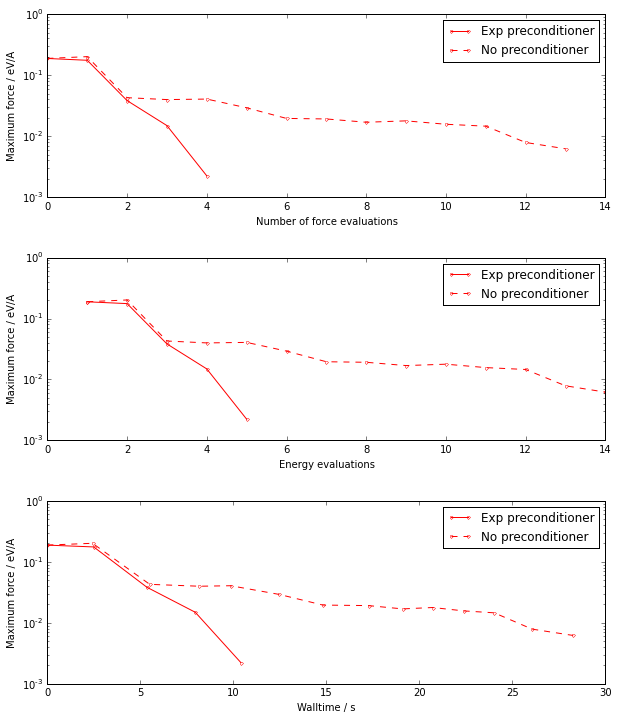

In [82]:
figsize(10,12)
log_calc.plot()
subplot(311); ylim(1e-3,1e0)
subplot(312); ylim(1e-3,1e0)
subplot(313); ylim(1e-3,1e0)
None

- Another good example would be automated convergence testing

# Conclusions and Outlook

- Scripting interfaces can be very useful for automating calculations, or connecting components in new ways
- Can give lecacy C/Fortran code a new lease of life
- Provides interactive environment for testing, debugging, development and visualisation
- Appropriate mix of high- and low-level languages maximses overall efficiency
- **CSC MSc [project](https://www2.warwick.ac.uk/fac/sci/csc/teaching/taughtdegrees/msc/projects/csc-msc-project-jameskermode-pythoncastep.pdf) available on extending Castep/Python interface**

#  Links and References
- `QUIP` developed with Gábor Csányi, Noam Bernstein, et al.
    - Code https://github.com/libAtoms/QUIP
    - Documentation http://libatoms.github.io/QUIP
- `matscipy` https://github.com/libAtoms/matscipy, developed with Lars Pastewka, KIT
- `f90wrap` https://github.com/jameskermode/f90wrap
- `chemview` https://github.com/gabrielelanaro/chemview/ by Gabriele Lanaro
- [RAL technical report](https://epubs.stfc.ac.uk/work/18048381) on Castep/Python interface:
  G Corbett, J Kermode, D Jochym and K Refson
